In [1]:
import pandas as pd
import numpy as np
import re


In [2]:
def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_CODEGEN_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27
1,LGBMClassifier,"'DS_CODEGEN_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,29
2,LGBMClassifier,"'DS_CODEGEN_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27
3,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27
4,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27


In [6]:
# df.elapsed_time.value_counts()

In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_CODEGEN_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27,lightgbm.sklearn
1,LGBMClassifier,"'DS_CODEGEN_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,29,lightgbm.sklearn
2,LGBMClassifier,"'DS_CODEGEN_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27,lightgbm.sklearn
3,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27,lightgbm.sklearn
4,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , 300, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'hive'," "'monetdb'," "'mssql'," "'mysql'," "'oracle',"
 "'pgsql'," "'sqltm'," "'teradata'," "'firebird',"]
df.shape (18646, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'db2', CalibratedClassifierCV_pipe 18 18
MODEL_DATASETS_MISSING 'db2', ExtraTreeClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'db2', IsolationForest_pipe 6 6
MODEL_DATASETS_MISSING 'db2', MLPClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'db2', RANSACRegressor 2 2
MODEL_DATASETS_MISSING 'hive', AdaBoostClassifier_pipe 18 12
MODEL_DATASETS_MISSING 'hive', BernoulliNB 18 11
MODEL_DATASETS_MISSING 'hive', BernoulliNB_pipe 18 18
MODEL_DATASETS_MISSING 'hive', CalibratedClassifierCV_pipe 18 15
MODEL_DATASETS_MISSING 'hive', ExtraTreesClassifier_pipe 18 16
MODEL_DATASETS_MISSING 'hive', GaussianNB_pipe 18 18
MODEL_DATASETS_MISSING 'hive', GradientBoostingClassifier 18 9
MODEL_DATASETS_MISSING 'hive

In [15]:
missing_data

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_50_7_0_1__2_3_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration
1,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_50_7_0_1__0_1_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration
2,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_50_7_0_1__8_9_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration
3,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_50_82_0_1__0_1_64F62F02',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration
4,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_50_82_0_1__2_3_64F62F02',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration
5,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_50_82_0_1__8_9_64F62F02',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration
6,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_200_22_0_1__0_1_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration
7,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_200_22_0_1__2_3_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration
8,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_200_22_0_1__8_9_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration
9,CalibratedClassifierCV_pipe,"'p_DS_CODEGEN_200_7_0_1__0_1_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.calibration


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(20480, 8)

In [19]:
df.est_dialect.value_counts()

'oracle',      2048
'pgsql',       2048
'mssql',       2048
'mysql',       2048
'monetdb',     2048
'hive',        2048
'teradata',    2048
'firebird',    2048
'db2',         2048
'sqltm',       2048
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

error_message
est_dialect error_message                                                    
'firebird', TIMEOUT                                                       691
'teradata', TIMEOUT                                                       469
'hive',     TIMEOUT                                                       317
'teradata', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  221
            'DatabaseError:(teradata.api.DatabaseError)                   190
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  155
'mysql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  145
'oracle',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  143
'sqltm',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  142
'pgsql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  139
'db2',      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  136
'mssql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  126
'hive',     "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  115
'monetdb',  TIMEOUT                                                       111
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  103
'pgsql',    TIMEOUT                                                        80
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      64
'db2',      TIMEOUT                                                        62
            'DBAPIError:(ibm_db_dbi.Error)                                 54
'hive',     ) TExecuteStatementResp(status=TStatus(statusCo...             45
'sqltm',    TIMEOUT                                                        44
'mssql',    TIMEOUT                                                        38
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)                      27
'mysql',    TIMEOUT                                                        20
'mssql',    "AttributeError:'NoneType'                                     18
'pgsql',    "AttributeError:'NoneType'                                     18
'mysql',    "AttributeError:'NoneType'                                     18
'monetdb',  "AttributeError:'NoneType'                                     18
'sqltm',    "AttributeError:'NoneType'                                     18
'hive',     "AttributeError:'NoneType'                                     18
...                                                                       ...
'pgsql',    ) target lists can have at most 1664 entrie                     6
'sqltm',    'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'oracle',   'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'pgsql',    'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'oracle',   'DatabaseError:(cx+Oracle.DatabaseError)                        3
'monetdb',  'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'teradata', 'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'mysql',    'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'db2',      'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'mssql',    'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'monetdb',  'DBAPIError:(builtins.BrokenPipeError)                          3
            "DatabaseError:(pymonetdb.exceptions.DatabaseEr...              3
'firebird', 'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'hive',     'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'db2',      'InternalError:(ibm_db_dbi.InternalError)                       2
'sqltm',    ) Expression tree is too large (maximum depth 1000              2
'hive',     ) TExecuteStatementResp(status=TStatus(statusCo...              2
            ) TExecuteStatementResp(status=TStatus(statusCo...              2
'mysql',    1436, "Thread stack overrun:  1237888 bytes use...              2
'pgsql',

In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,16539
TIMEOUT,1834
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",1425
'DatabaseError:(teradata.api.DatabaseError),190
"""AttributeError:'NoneType'",180
'DatabaseError:(fdb.fbcore.DatabaseError),64
'DBAPIError:(ibm_db_dbi.Error),54
") TExecuteStatementResp(status=TStatus(statusCode=3, infoMessages=['*org.apache.hive.service.cli.HiveSQLException:Error while processing statement: FAILED: Execution Error, return code 1 from org.apache.hadoop.hive.ql.exec.mr.MapRedTask:28:27', 'org.apache.hive.service.cli.operation.Operation:toSQLException:Operation.java:400', 'org.apache.hive.service.cli.operation.SQLOperation:runQuery:SQLOperation.java:238', 'org.apache.hive.service.cli.operation.SQLOperation:runIn""),",45
'Exception:TOO_LARGE_SQL_UNION_AVOIDED,30
"""DatabaseError:(fdb.fbcore.DatabaseError)",27


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
real_errors = df[df.error_message == '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS']

In [27]:
real_errors.Model.value_counts()

DummyClassifier                180
MiniBatchSparsePCA             180
SparsePCA                      180
LatentDirichletAllocation      168
NMF                            168
DummyClassifier_pipe           162
OneVsRestClassifier             68
IsolationForest                 51
IsolationForest_pipe            45
NuSVC_pipe                      36
FastICA                         27
OneVsRestClassifier_pipe        21
FactorAnalysis                  18
GradientBoostingClassifier      18
XGBClassifier                   18
LGBMClassifier                  16
Lars                             9
SVC                              9
NuSVC                            6
RandomForestClassifier           3
CalibratedClassifierCV           3
DecisionTreeClassifier           3
DecisionTreeClassifier_pipe      3
ExtraTreeClassifier_pipe         3
CalibratedClassifierCV_pipe      3
ExtraTreesClassifier             3
SVR_pipe                         3
Pipeline_pipe                    3
OneClassSVM         

In [28]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [29]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [30]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_CODEGEN_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27,lightgbm.sklearn
1,LGBMClassifier,"'DS_CODEGEN_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,29,lightgbm.sklearn
2,LGBMClassifier,"'DS_CODEGEN_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27,lightgbm.sklearn
3,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27,lightgbm.sklearn
4,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,27,lightgbm.sklearn


In [31]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [32]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']

In [33]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_CODEGEN_200_22_0_1__0_1_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,27,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_CODEGEN_200_22_0_1__2_3_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,29,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_CODEGEN_200_22_0_1__8_9_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,27,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_CODEGEN_200_7_0_1__0_1_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,27,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_CODEGEN_200_7_0_1__2_3_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,27,lightgbm.sklearn,1,db2


In [34]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                            \
dialect                         db2 firebird  hive monetdb mssql mysql oracle   
model_category                                                                  
lightgbm.sklearn                 48       48    48      48    48    48     48   
sklearn.calibration              36       36    36      36    36    36     36   
sklearn.covariance               12       12    12      12    12    12     12   
sklearn.decomposition           180      180   180     180   180   180    180   
sklearn.discriminant_analysis    36       36    36      36    36    36     36   
sklearn.ensemble                252      252   252     252   252   252    252   
sklearn.feature_selection       162      162   162     162   162   162    162   
sklearn.kernel_ridge             12       12    12      12    12    12     12   
sklearn.linear_model            482      482   482     482   482   482    482   
sklearn.multiclass               72       72    72      72    72    72     72   
sklearn.naive_bayes              90       90    90      90    90    90     90   
sklearn.neural_network           48       48    48      48    48    48     48   
sklearn.pipeline                 54       54    54      54    54    54     54   
sklearn.preprocessing           216      216   216     216   216   216    216   
sklearn.svm                     156      156   156     156   156   156    156   
sklearn.tree                     96       96    96      96    96    96     96   
xgboost.sklearn                  48       48    48      48    48    48     48   
All                            2000     2000  2000    2000  2000  2000   2000   

                                                           
dialect                       pgsql sqltm teradata    All  
model_category                                             
lightgbm.sklearn                 48    48       48    480  
sklearn.calibration              36    36       36    360  
sklearn.covariance               12    12       12    120  
sklearn.decomposition           180   180      180   1800  
sklearn.discriminant_analysis    36    36       36    360  
sklearn.ensemble                252   252      252   2520  
sklearn.feature_selection       162   162      162   1620  
sklearn.kernel_ridge             12    12       12    120  
sklearn.linear_model            482   482      482   4820  
sklearn.multiclass               72    72       72    720  
sklearn.naive_bayes              90    90       90    900  
sklearn.neural_network           48    48       48    480  
sklearn.pipeline                 54    54       54    540  
sklearn.preprocessing           216   216      216   2160  
sklearn.svm                     156   156      156   1560  
sklearn.tree                     96    96       96    960  
xgboost.sklearn                  48    48       48    480  
All                            2000  2000     2000  20000

In [35]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [36]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird      hive   monetdb   
model_category                                                          
lightgbm.sklearn               0.000000  0.895833  0.645833  0.000000   
sklearn.calibration            0.500000  1.000000  0.416667  0.000000   
sklearn.covariance             0.166667  0.166667  0.166667  0.666667   
sklearn.decomposition          0.516667  0.550000  0.516667  0.616667   
sklearn.discriminant_analysis  0.000000  0.500000  0.000000  0.027778   
sklearn.ensemble               0.047619  0.821429  0.519841  0.047619   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.083333  0.666667  0.083333  0.083333   
sklearn.linear_model           0.008299  0.265560  0.002075  0.004149   
sklearn.multiclass             0.166667  0.944444  0.666667  0.166667   
sklearn.naive_bayes            0.066667  0.666667  0.700000  0.655556   
sklearn.neural_network         1.000000  0.750000  0.500000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.111111  0.083333  0.000000  0.046296   
sklearn.svm                    0.057692  0.711538  0.275641  0.301282   
sklearn.tree                   0.187500  0.000000  0.000000  0.000000   
xgboost.sklearn                0.000000  0.750000  0.645833  0.000000   
All                            0.123500  0.435000  0.241500  0.131500   

                                                                       \
dialect                           mssql     mysql    oracle     pgsql   
model_category                                                          
lightgbm.sklearn               0.000000  0.000000  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.166667  0.083333  0.166667   
sklearn.decomposition          0.516667  0.516667  0.516667  0.516667   
sklearn.discriminant_analysis  0.000000  0.000000  0.000000  0.000000   
sklearn.ensemble               0.055556  0.047619  0.047619  0.047619   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.083333  0.083333  0.083333  0.083333   
sklearn.linear_model           0.006224  0.043568  0.006224  0.093361   
sklearn.multiclass             0.166667  0.208333  0.194444  0.625000   
sklearn.naive_bayes            0.000000  0.000000  0.000000  0.066667   
sklearn.neural_network         0.000000  0.000000  0.020833  0.000000   
sklearn.pipeline               0.333333  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.000000  0.000000  0.000000  0.027778   
sklearn.svm                    0.051282  0.051282  0.051282  0.051282   
sklearn.tree                   0.000000  0.000000  0.000000  0.000000   
xgboost.sklearn                0.000000  0.000000  0.000000  0.000000   
All                            0.075500  0.076000  0.066500  0.109000   

                                                             
dialect                           sqltm  teradata       All  
model_category                                               
lightgbm.sklearn               0.125000  0.916667  0.258333  
sklearn.calibration            0.000000  1.000000  0.291667  
sklearn.covariance             0.166667  0.166667  0.208333  
sklearn.decomposition          0.516667  0.533333  0.531667  
sklearn.discriminant_analysis  0.000000  0.361111  0.088889  
sklearn.ensemble               0.047619  0.888889  0.257143  
sklearn.feature_selection      0.000000  0.000000  0.000000  
sklearn.kernel_ridge           0.083333  0.583333  0.191667  
sklearn.linear_model           0.043568  0.072614  0.054564  
sklearn.multiclass             0.166667  0.875000  0.418056  
sklearn.naive_bayes            0.000000  0.966667  0.312222  
sklearn.neural_network         0.000000  0.375000  0.264583  
sklearn.pipeline               0.0000

In [37]:
df.to_csv('report_extensive_tests.csv')

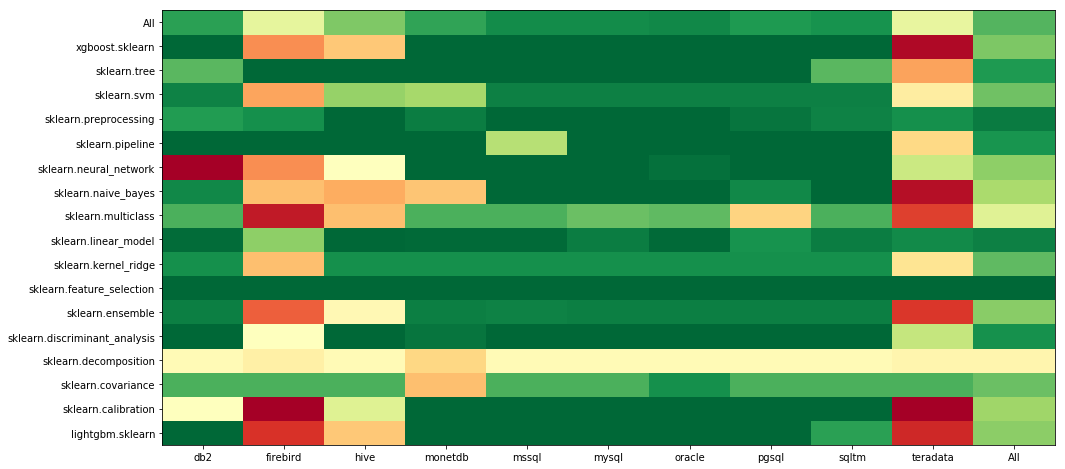

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn')
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [39]:
Category_Labels = df.model_category.unique()


In [40]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [41]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  48
'firebird', TIMEOUT                                                  43
            SUCCESS                                                   5
'hive',     TIMEOUT                                                  31
            SUCCESS                                                  17
'monetdb',  SUCCESS                                                  48
'mssql',    SUCCESS                                                  48
'mysql',    SUCCESS                                                  48
'oracle',   SUCCESS                                                  48
'pgsql',    SUCCESS                                                  48
'sqltm',    SUCCESS                                                  42
            TIMEOUT                                                   6
'teradata', TIMEOUT                                                  20
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             16
            'DatabaseError:(teradata.api.DatabaseError)               8
            SUCCESS                                                   4

mean                                                       \
dialect              db2  firebird      hive monetdb mssql mysql oracle pgsql   
Model                                                                           
LGBMClassifier       0.0  1.000000  0.722222     0.0   0.0   0.0    0.0   0.0   
LGBMClassifier_pipe  0.0  1.000000  1.000000     0.0   0.0   0.0    0.0   0.0   
LGBMRegressor        0.0  0.166667  0.000000     0.0   0.0   0.0    0.0   0.0   
LGBMRegressor_pipe   0.0  1.000000  0.000000     0.0   0.0   0.0    0.0   0.0   
All                  0.0  0.895833  0.645833     0.0   0.0   0.0    0.0   0.0   

                                                
dialect              sqltm  teradata       All  
Model                                           
LGBMClassifier       0.000  1.000000  0.272222  
LGBMClassifier_pipe  0.000  1.000000  0.300000  
LGBMRegressor        0.000  0.500000  0.066667  
LGBMRegressor_pipe   1.000  0.833333  0.283333  
All                  0.125  0.916667  0.258333

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  18
            TIMEOUT                                                  18
'firebird', TIMEOUT                                                  36
'hive',     SUCCESS                                                  21
            TIMEOUT                                                  15
'monetdb',  SUCCESS                                                  36
'mssql',    SUCCESS                                                  36
'mysql',    SUCCESS                                                  36
'oracle',   SUCCESS                                                  36
'pgsql',    SUCCESS                                                  36
'sqltm',    SUCCESS                                                  36
'teradata', 'DatabaseError:(teradata.api.DatabaseError)              16
            TIMEOUT                                                  14
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6

mean                                         \
dialect                      db2 firebird      hive monetdb mssql mysql   
Model                                                                     
CalibratedClassifierCV       0.0      1.0  0.000000     0.0   0.0   0.0   
CalibratedClassifierCV_pipe  1.0      1.0  0.833333     0.0   0.0   0.0   
All                          0.5      1.0  0.416667     0.0   0.0   0.0   

                                                                   
dialect                     oracle pgsql sqltm teradata       All  
Model                                                              
CalibratedClassifierCV         0.0   0.0   0.0      1.0  0.200000  
CalibratedClassifierCV_pipe    0.0   0.0   0.0      1.0  0.383333  
All                            0.0   0.0   0.0      1.0  0.291667

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        10
            'InternalError:(ibm_db_dbi.InternalError)                       2
'firebird', SUCCESS                                                        10
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'hive',     SUCCESS                                                        10
            ) TExecuteStatementResp(status=TStatus(statusCo...              2
'monetdb',  TIMEOUT                                                         7
            SUCCESS                                                         4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'mysql',    SUCCESS                                                        10
            1436, "Thread stack overrun:  1237888 bytes use...              2
'oracle',   SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird      hive   monetdb     mssql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  1.000000  0.000000   
All                    0.166667  0.166667  0.166667  0.666667  0.166667   

                                                                         \
dialect                   mysql    oracle     pgsql     sqltm  teradata   
Model                                                                     
EllipticEnvelope       0.333333  0.166667  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  0.000000   
All                    0.166667  0.083333  0.166667  0.166667  0.166667   

                                 
dialect                     All  
Model                            
EllipticEnvelope       0.316667  
EllipticEnvelope_pipe  0.100000  
All                    0.208333

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'firebird', SUCCESS                                                  81
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             54
            "AttributeError:'NoneType'                               18
            "DatabaseError:(fdb.fbcore.DatabaseError)                15
            'DatabaseError:(fdb.fbcore.DatabaseError)                12
'hive',     SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             93
            SUCCESS                                                  69
            "AttributeError:'NoneType'                               18
'mssql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'mysql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'oracle',   SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'pgsql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'sqltm',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'teradata', SUCCESS                                                  84
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             69
            "AttributeError:'NoneType'                               18
            'DatabaseError:(teradata.api.DatabaseError)               6
            TIMEOUT                                                   3

mean                                          \
dialect                         db2  firebird      hive   monetdb     mssql   
Model                                                                         
FactorAnalysis             0.000000  0.000000  0.000000  1.000000  0.000000   
FastICA                    0.166667  0.333333  0.166667  0.166667  0.166667   
IncrementalPCA             0.000000  0.000000  0.000000  0.000000  0.000000   
KernelPCA                  1.000000  1.000000  1.000000  1.000000  1.000000   
LatentDirichletAllocation  1.000000  1.000000  1.000000  1.000000  1.000000   
MiniBatchSparsePCA         1.000000  1.000000  1.000000  1.000000  1.000000   
NMF                        1.000000  1.000000  1.000000  1.000000  1.000000   
PCA                        0.000000  0.000000  0.000000  0.000000  0.000000   
SparsePCA                  1.000000  1.000000  1.000000  1.000000  1.000000   
TruncatedSVD               0.000000  0.166667  0.000000  0.000000  0.000000   
All                        0.516667  0.550000  0.516667  0.616667  0.516667   

                                                                             \
dialect                       mysql    oracle     pgsql     sqltm  teradata   
Model                                                                         
FactorAnalysis             0.000000  0.000000  0.000000  0.000000  0.000000   
FastICA                    0.166667  0.166667  0.166667  0.166667  0.333333   
IncrementalPCA             0.000000  0.000000  0.000000  0.000000  0.000000   
KernelPCA                  1.000000  1.000000  1.000000  1.000000  1.000000   
LatentDirichletAllocation  1.000000  1.000000  1.000000  1.000000  1.000000   
MiniBatchSparsePCA         1.000000  1.000000  1.000000  1.000000  1.000000   
NMF                        1.000000  1.000000  1.000000  1.000000  1.000000   
PCA                        0.000000  0.000000  0.000000  0.000000  0.000000   
SparsePCA                  1.000000  1.000000  1.000000  1.000000  1.000000   
TruncatedSVD               0.000000  0.000000  0.000000  0.000000  0.000000   
All                        0.516667  0.516667  0.516667  0.516667  0.533333   

                                     
dialect                         All  
Model                                
FactorAnalysis             0.100000  
FastICA                    0.200000  
IncrementalPCA             0.000000  
KernelPCA                  1.000000  
LatentDirichletAllocation  1.000000  
MiniBatchSparsePCA         1.000000  
NMF                        1.000000  
PCA                        0.000000  
SparsePCA                  1.000000  
TruncatedSVD               0.016667  
All                        0.531667

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                                        
'db2',      SUCCESS                                            36
'firebird', SUCCESS                                            18
            TIMEOUT                                            18
'hive',     SUCCESS                                            36
'monetdb',  SUCCESS                                            35
            'DBAPIError:(builtins.BrokenPipeError)              1
'mssql',    SUCCESS                                            36
'mysql',    SUCCESS                                            36
'oracle',   SUCCESS                                            36
'pgsql',    SUCCESS                                            36
'sqltm',    SUCCESS                                            36
'teradata', SUCCESS                                            23
            TIMEOUT                                            13

mean                                      \
dialect                          db2 firebird hive   monetdb mssql mysql   
Model                                                                      
LinearDiscriminantAnalysis       0.0      0.0  0.0  0.055556   0.0   0.0   
LinearDiscriminantAnalysis_pipe  0.0      1.0  0.0  0.000000   0.0   0.0   
All                              0.0      0.5  0.0  0.027778   0.0   0.0   

                                                                        
dialect                         oracle pgsql sqltm  teradata       All  
Model                                                                   
LinearDiscriminantAnalysis         0.0   0.0   0.0  0.000000  0.005556  
LinearDiscriminantAnalysis_pipe    0.0   0.0   0.0  0.722222  0.172222  
All                                0.0   0.0   0.0  0.361111  0.088889

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            TIMEOUT                                                         6
'firebird', TIMEOUT                                                       195
            SUCCESS                                                        45
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'hive',     SUCCESS                                                       121
            TIMEOUT                                                        71
            ) TExecuteStatementResp(status=TStatus(statusCo...             45
            ) TExecuteStatementResp(status=TStatus(statusCo...             11
            ) TExecuteStatementResp(status=TStatus(statusCo...              1
            ) TExecuteStatementResp(status=TStatus(statusCo...              1
            ) TExecuteStatementResp(status=TStatus(statusCo...              1
            ) TExecuteStatementResp(status=TStatus(statusCo...              1
'monetdb',  SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mssql',    SUCCESS                                                       238
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   14
'mysql',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'oracle',   SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'pgsql',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'sqltm',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'teradata', TIMEOUT                                                       119
            'DatabaseError:(teradata.api.DatabaseError)                    75
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   30
            SUCCESS                                                        28

mean                                \
dialect                               db2  firebird      hive   monetdb   
Model                                                                     
AdaBoostClassifier               0.000000  1.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  1.000000  0.666667  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.944444  1.000000  0.000000   
BaggingClassifier_pipe           0.000000  1.000000  0.833333  0.000000   
BaggingRegressor                 0.000000  0.333333  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  1.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  1.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.000000  1.000000  0.888889  0.000000   
ExtraTreesRegressor              0.000000  0.500000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  1.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  1.000000  0.666667  0.000000   
GradientBoostingClassifier_pipe  0.000000  1.000000  1.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.944444  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  1.000000  0.888889  0.000000   
RandomForestRegressor            0.000000  0.000000  1.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  1.000000  0.000000   
All                              0.047619  0.821429  0.519841  0.047619   

                                                                         \
dialect                             mssql     mysql    oracle     pgsql   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.111111  0.000000  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.055556  0.047619  0.047619  0.047619   

                                                               
dialect                             sqltm  teradata       All  
Model  

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,162
"'firebird',",SUCCESS,162
"'hive',",SUCCESS,162
"'monetdb',",SUCCESS,162
"'mssql',",SUCCESS,162
"'mysql',",SUCCESS,162
"'oracle',",SUCCESS,162
"'pgsql',",SUCCESS,162
"'sqltm',",SUCCESS,162


mean                                                 \
dialect                  db2 firebird hive monetdb mssql mysql oracle pgsql   
Model                                                                         
GenericUnivariateSelect    0        0    0       0     0     0      0     0   
RFE                        0        0    0       0     0     0      0     0   
RFECV                      0        0    0       0     0     0      0     0   
SelectFdr                  0        0    0       0     0     0      0     0   
SelectFpr                  0        0    0       0     0     0      0     0   
SelectFromModel            0        0    0       0     0     0      0     0   
SelectFwe                  0        0    0       0     0     0      0     0   
SelectKBest                0        0    0       0     0     0      0     0   
SelectPercentile           0        0    0       0     0     0      0     0   
All                        0        0    0       0     0     0      0     0   

                                            
dialect                 sqltm teradata All  
Model                                       
GenericUnivariateSelect     0        0   0  
RFE                         0        0   0  
RFECV                       0        0   0  
SelectFdr                   0        0   0  
SelectFpr                   0        0   0  
SelectFromModel             0        0   0  
SelectFwe                   0        0   0  
SelectKBest                 0        0   0  
SelectPercentile            0        0   0  
All                         0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1
'firebird', TIMEOUT                                                  6
            SUCCESS                                                  4
            'DatabaseError:(fdb.fbcore.DatabaseError)                1
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1
'hive',     SUCCESS                                                 11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1
'monetdb',  SUCCESS                                                 11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1
'mssql',    SUCCESS                                                 11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1
'mysql',    SUCCESS                                                 11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1
'oracle',   SUCCESS                                                 11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1
'pgsql',    SUCCESS                                                 11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1
'sqltm',    SUCCESS                                                 11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1
'teradata', 'DatabaseError:(teradata.api.DatabaseError)              6
            SUCCESS                                                  5
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                   1

mean                                                    \
dialect                db2  firebird      hive   monetdb     mssql     mysql   
Model                                                                          
KernelRidge       0.166667  0.333333  0.166667  0.166667  0.166667  0.166667   
KernelRidge_pipe  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
All               0.083333  0.666667  0.083333  0.083333  0.083333  0.083333   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
KernelRidge       0.166667  0.166667  0.166667  0.666667  0.233333  
KernelRidge_pipe  0.000000  0.000000  0.000000  0.500000  0.150000  
All               0.083333  0.083333  0.083333  0.583333  0.191667

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       478
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                       354
            TIMEOUT                                                       127
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'hive',     SUCCESS                                                       481
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'monetdb',  SUCCESS                                                       480
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            'DBAPIError:(builtins.BrokenPipeError)                          1
'mssql',    SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mysql',    SUCCESS                                                       461
            TIMEOUT                                                        20
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'oracle',   SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                       437
            TIMEOUT                                                        44
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'sqltm',    SUCCESS                                                       461
            TIMEOUT                                                        20
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'teradata', SUCCESS                                                       447
            TIMEOUT                                                        34
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                \
dialect                                db2  firebird      hive   monetdb   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.000000  0.000000  0.000000  0.000000   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000  0.000000   
Lars                              0.166667  0.166667  0.166667  0.166667   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000  0.000000   
Lars_pipe                         0.000000  0.000000  0.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000  0.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLars_pipe                    0.000000  0.000000  0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000  0.000000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.000000  0.000000  0.000000  0.000000   
LogisticRegression                0.000000  0.000000  0.000000  0.000000   
LogisticRegressionCV              0.000000  0.055556  0.000000  0.055556   
LogisticRegressionCV_pipe         0.055556  1.000000  0.000000  0.000000   
LogisticRegression_pipe           0.000000  1.000000  0.000000  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  1.000000  0.000000  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
Perceptron                        0.000000  0.000000  0.000000  0.000000   
Perceptron_pipe                   0.000000  1.000000  0.000000  0.000000   
RANSACRegressor                   1.000000  0.000000  0.000000  0.000000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  1.000000  0.000000  0.000000   
RidgeClassifier_pipe              0.000000  1.000000  0.000000  0.000000   
Ridge_pipe                        0.000000  0.000000  0.000000  0.000000   
SGDClassifier                     0.000000  0.000000  0.000000  0.000000   
SGDClassifier_pipe                0.000000  1.000000  0.000000  0.000000   
SGDRegressor                      0.000000  0.000000  0.000000  0.000000   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'firebird', TIMEOUT                                                  53
            'DatabaseError:(fdb.fbcore.DatabaseError)                15
            SUCCESS                                                   4
'hive',     TIMEOUT                                                  45
            SUCCESS                                                  24
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'monetdb',  SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'mssql',    SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'mysql',    SUCCESS                                                  57
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             15
'oracle',   SUCCESS                                                  58
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
            'DatabaseError:(cx+Oracle.DatabaseError)                  2
'pgsql',    TIMEOUT                                                  36
            SUCCESS                                                  27
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              9
'sqltm',    SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'teradata', TIMEOUT                                                  52
            SUCCESS                                                   9
            'DatabaseError:(teradata.api.DatabaseError)               6
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              5

mean                                          \
dialect                        db2  firebird      hive   monetdb     mssql   
Model                                                                        
OneVsOneClassifier        0.000000  0.944444  0.000000  0.000000  0.000000   
OneVsOneClassifier_pipe   0.000000  1.000000  0.833333  0.000000  0.000000   
OneVsRestClassifier       0.500000  0.833333  0.833333  0.500000  0.500000   
OneVsRestClassifier_pipe  0.166667  1.000000  1.000000  0.166667  0.166667   
All                       0.166667  0.944444  0.666667  0.166667  0.166667   

                                                                        \
dialect                      mysql    oracle  pgsql     sqltm teradata   
Model                                                                    
OneVsOneClassifier        0.000000  0.111111  0.000  0.000000    0.500   
OneVsOneClassifier_pipe   0.000000  0.000000  1.000  0.000000    1.000   
OneVsRestClassifier       0.500000  0.500000  0.500  0.500000    1.000   
OneVsRestClassifier_pipe  0.333333  0.166667  1.000  0.166667    1.000   
All                       0.208333  0.194444  0.625  0.166667    0.875   

                                    
dialect                        All  
Model                               
OneVsOneClassifier        0.155556  
OneVsOneClassifier_pipe   0.383333  
OneVsRestClassifier       0.616667  
OneVsRestClassifier_pipe  0.516667  
All                       0.418056

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        84
            'DBAPIError:(ibm_db_dbi.Error)                                  6
'firebird', TIMEOUT                                                        36
            SUCCESS                                                        30
            "DatabaseError:(fdb.fbcore.DatabaseError)                      12
            'DatabaseError:(fdb.fbcore.DatabaseError)                      12
'hive',     TIMEOUT                                                        59
            SUCCESS                                                        27
            ) TExecuteStatementResp(status=TStatus(statusCo...              2
            ) TExecuteStatementResp(status=TStatus(statusCo...              1
            ) TExecuteStatementResp(status=TStatus(statusCo...              1
'monetdb',  TIMEOUT                                                        52
            SUCCESS                                                        31
            ) Math exception: Numerical result out of rang                  6
            'DBAPIError:(builtins.BrokenPipeError)                          1
'mssql',    SUCCESS                                                        90
'mysql',    SUCCESS                                                        90
'oracle',   SUCCESS                                                        90
'pgsql',    SUCCESS                                                        84
            ) value out of range: underflo                                  6
'sqltm',    SUCCESS                                                        90
'teradata', TIMEOUT                                                        84
            'DatabaseError:(teradata.api.DatabaseError)                     3
            SUCCESS                                                         3

mean                                                   \
dialect                db2  firebird      hive   monetdb mssql mysql oracle   
Model                                                                         
BernoulliNB       0.000000  1.000000  0.666667  0.722222   0.0   0.0    0.0   
BernoulliNB_pipe  0.000000  1.000000  1.000000  1.000000   0.0   0.0    0.0   
GaussianNB        0.333333  0.333333  0.444444  0.500000   0.0   0.0    0.0   
GaussianNB_pipe   0.000000  1.000000  1.000000  1.000000   0.0   0.0    0.0   
MultinomialNB     0.000000  0.000000  0.388889  0.055556   0.0   0.0    0.0   
All               0.066667  0.666667  0.700000  0.655556   0.0   0.0    0.0   

                                                      
dialect              pgsql sqltm  teradata       All  
Model                                                 
BernoulliNB       0.000000   0.0  1.000000  0.338889  
BernoulliNB_pipe  0.000000   0.0  1.000000  0.400000  
GaussianNB        0.333333   0.0  1.000000  0.294444  
GaussianNB_pipe   0.000000   0.0  1.000000  0.400000  
MultinomialNB     0.000000   0.0  0.833333  0.127778  
All               0.066667   0.0  0.966667  0.312222

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                          
'db2',      'DBAPIError:(ibm_db_dbi.Error)                       30
            TIMEOUT                                              18
'firebird', TIMEOUT                                              36
            SUCCESS                                              12
'hive',     SUCCESS                                              24
            TIMEOUT                                              24
'monetdb',  SUCCESS                                              48
'mssql',    SUCCESS                                              48
'mysql',    SUCCESS                                              48
'oracle',   SUCCESS                                              47
            'DatabaseError:(cx+Oracle.DatabaseError)              1
'pgsql',    SUCCESS                                              48
'sqltm',    SUCCESS                                              48
'teradata', SUCCESS                                              30
            TIMEOUT                                              18

mean                                                   \
dialect             db2 firebird      hive monetdb mssql mysql    oracle   
Model                                                                      
MLPClassifier       1.0     1.00  0.333333     0.0   0.0   0.0  0.000000   
MLPClassifier_pipe  1.0     1.00  1.000000     0.0   0.0   0.0  0.000000   
MLPRegressor        1.0     0.00  0.000000     0.0   0.0   0.0  0.000000   
MLPRegressor_pipe   1.0     0.00  0.000000     0.0   0.0   0.0  0.166667   
All                 1.0     0.75  0.500000     0.0   0.0   0.0  0.020833   

                                                   
dialect            pgsql sqltm teradata       All  
Model                                              
MLPClassifier        0.0   0.0    0.000  0.233333  
MLPClassifier_pipe   0.0   0.0    1.000  0.400000  
MLPRegressor         0.0   0.0    0.000  0.100000  
MLPRegressor_pipe    0.0   0.0    0.000  0.116667  
All                  0.0   0.0    0.375  0.264583

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  54
'firebird', SUCCESS                                                  54
'hive',     SUCCESS                                                  54
'monetdb',  SUCCESS                                                  54
'mssql',    SUCCESS                                                  36
            TIMEOUT                                                  18
'mysql',    SUCCESS                                                  54
'oracle',   SUCCESS                                                  54
'pgsql',    SUCCESS                                                  54
'sqltm',    SUCCESS                                                  54
'teradata', SUCCESS                                                  21
            TIMEOUT                                                  15
            'DatabaseError:(teradata.api.DatabaseError)              12
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6

mean                                                           \
dialect        db2 firebird hive monetdb     mssql mysql oracle pgsql sqltm   
Model                                                                         
FeatureUnion   0.0      0.0  0.0     0.0  0.000000   0.0    0.0   0.0   0.0   
Pipeline       0.0      0.0  0.0     0.0  0.000000   0.0    0.0   0.0   0.0   
Pipeline_pipe  0.0      0.0  0.0     0.0  1.000000   0.0    0.0   0.0   0.0   
All            0.0      0.0  0.0     0.0  0.333333   0.0    0.0   0.0   0.0   

                                   
dialect        teradata       All  
Model                              
FeatureUnion   0.000000  0.000000  
Pipeline       0.833333  0.083333  
Pipeline_pipe  1.000000  0.200000  
All            0.611111  0.094444

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       192
            'DBAPIError:(ibm_db_dbi.Error)                                 18
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
'firebird', SUCCESS                                                       198
            'DatabaseError:(fdb.fbcore.DatabaseError)                      18
'hive',     SUCCESS                                                       216
'monetdb',  SUCCESS                                                       206
            TIMEOUT                                                        10
'mssql',    SUCCESS                                                       216
'mysql',    SUCCESS                                                       216
'oracle',   SUCCESS                                                       216
'pgsql',    SUCCESS                                                       210
            ) target lists can have at most 1664 entrie                     6
'sqltm',    SUCCESS                                                       204
            ) too many columns in result se                                 6
            ) too many terms in compound SELEC                              6
'teradata', SUCCESS                                                       198
            TIMEOUT                                                        12
            "DatabaseError:(teradata.api.DatabaseError)                     6

mean                                              \
dialect                   db2  firebird hive   monetdb mssql mysql oracle   
Model                                                                       
Binarizer            0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
Imputer              0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
LabelBinarizer       0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
LabelEncoder         0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
MaxAbsScaler         0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
MinMaxScaler         0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
Normalizer           0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
OneHotEncoder        0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
PolynomialFeatures   0.333333  0.333333  0.0  0.555556   0.0   0.0    0.0   
QuantileTransformer  1.000000  0.666667  0.0  0.000000   0.0   0.0    0.0   
RobustScaler         0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
StandardScaler       0.000000  0.000000  0.0  0.000000   0.0   0.0    0.0   
All                  0.111111  0.083333  0.0  0.046296   0.0   0.0    0.0   

                                                             
dialect                 pgsql     sqltm  teradata       All  
Model                                                        
Binarizer            0.000000  0.000000  0.000000  0.000000  
Imputer              0.000000  0.000000  0.000000  0.000000  
LabelBinarizer       0.000000  0.000000  0.000000  0.000000  
LabelEncoder         0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler         0.000000  0.000000  0.000000  0.000000  
MinMaxScaler         0.000000  0.000000  0.000000  0.000000  
Normalizer           0.000000  0.000000  0.000000  0.000000  
OneHotEncoder        0.000000  0.000000  0.000000  0.000000  
PolynomialFeatures   0.333333  0.333333  0.333333  0.222222  
QuantileTransformer  0.000000  0.333333  0.666667  0.266667  
RobustScaler         0.000000  0.000000  0.000000  0.000000  
StandardScaler       0.000000  0.000000  0.000000  0.000000  
All                  0.027778  0.055556  0.083333  0.040741

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       147
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', TIMEOUT                                                       105
            SUCCESS                                                        45
            'DatabaseError:(fdb.fbcore.DatabaseError)                       4
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'hive',     SUCCESS                                                       113
            TIMEOUT                                                        41
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'monetdb',  SUCCESS                                                       109
            TIMEOUT                                                        42
            "DatabaseError:(pymonetdb.exceptions.DatabaseEr...              3
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'mssql',    SUCCESS                                                       148
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'mysql',    SUCCESS                                                       148
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'oracle',   SUCCESS                                                       148
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'pgsql',    SUCCESS                                                       148
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'sqltm',    SUCCESS                                                       148
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'teradata', SUCCESS                                                        69
            TIMEOUT                                                        54
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   26
            'DatabaseError:(teradata.api.DatabaseError)                     5
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2

mean                                                    \
dialect                db2  firebird      hive   monetdb     mssql     mysql   
Model                                                                          
LinearSVC         0.000000  0.000000  0.000000  0.166667  0.000000  0.000000   
LinearSVC_pipe    0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVC             0.000000  0.944444  0.166667  0.166667  0.000000  0.000000   
NuSVC_pipe        0.333333  1.000000  1.000000  1.000000  0.333333  0.333333   
NuSVR             0.000000  0.166667  0.000000  0.000000  0.000000  0.000000   
NuSVR_pipe        0.166667  0.833333  0.000000  0.000000  0.000000  0.000000   
OneClassSVM       0.166667  0.333333  0.166667  0.166667  0.166667  0.166667   
OneClassSVM_pipe  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
SVC               0.000000  0.944444  0.111111  0.166667  0.000000  0.000000   
SVC_pipe          0.000000  1.000000  1.000000  1.000000  0.000000  0.000000   
SVR               0.166667  0.500000  0.166667  0.166667  0.166667  0.166667   
SVR_pipe          0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
All               0.057692  0.711538  0.275641  0.301282  0.051282  0.051282   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
LinearSVC         0.000000  0.000000  0.000000  0.000000  0.016667  
LinearSVC_pipe    0.000000  0.000000  0.000000  0.000000  0.100000  
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  
NuSVC             0.000000  0.000000  0.000000  1.000000  0.227778  
NuSVC_pipe        0.333333  0.333333  0.333333  1.000000  0.600000  
NuSVR             0.000000  0.000000  0.000000  0.333333  0.050000  
NuSVR_pipe        0.000000  0.000000  0.000000  0.166667  0.116667  
OneClassSVM       0.166667  0.166667  0.166667  0.666667  0.233333  
OneClassSVM_pipe  0.000000  0.000000  0.000000  0.333333  0.133333  
SVC               0.000000  0.000000  0.000000  0.944444  0.216667  
SVC_pipe          0.000000  0.000000  0.000000  1.000000  0.400000  
SVR               0.166667  0.166667  0.166667  0.500000  0.233333  
SVR_pipe          0.000000  0.000000  0.000000  0.666667  0.166667  
All               0.051282  0.051282  0.051282  0.557692  0.216026

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  78
            TIMEOUT                                                  18
'firebird', SUCCESS                                                  96
'hive',     SUCCESS                                                  96
'monetdb',  SUCCESS                                                  96
'mssql',    SUCCESS                                                  96
'mysql',    SUCCESS                                                  96
'oracle',   SUCCESS                                                  96
'pgsql',    SUCCESS                                                  96
'sqltm',    SUCCESS                                                  78
            TIMEOUT                                                  18
'teradata', 'DatabaseError:(teradata.api.DatabaseError)              39
            SUCCESS                                                  27
            TIMEOUT                                                  13
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              9
            "DatabaseError:(teradata.api.DatabaseError)               8

mean                                           \
dialect                         db2 firebird hive monetdb mssql mysql oracle   
Model                                                                          
DecisionTreeClassifier       0.0000      0.0  0.0     0.0   0.0   0.0    0.0   
DecisionTreeClassifier_pipe  0.0000      0.0  0.0     0.0   0.0   0.0    0.0   
DecisionTreeRegressor        0.0000      0.0  0.0     0.0   0.0   0.0    0.0   
DecisionTreeRegressor_pipe   0.0000      0.0  0.0     0.0   0.0   0.0    0.0   
ExtraTreeClassifier          0.0000      0.0  0.0     0.0   0.0   0.0    0.0   
ExtraTreeClassifier_pipe     1.0000      0.0  0.0     0.0   0.0   0.0    0.0   
ExtraTreeRegressor           0.0000      0.0  0.0     0.0   0.0   0.0    0.0   
ExtraTreeRegressor_pipe      0.0000      0.0  0.0     0.0   0.0   0.0    0.0   
All                          0.1875      0.0  0.0     0.0   0.0   0.0    0.0   

                                                               
dialect                     pgsql   sqltm  teradata       All  
Model                                                          
DecisionTreeClassifier        0.0  0.0000  0.833333  0.083333  
DecisionTreeClassifier_pipe   0.0  0.0000  1.000000  0.100000  
DecisionTreeRegressor         0.0  0.0000  0.000000  0.000000  
DecisionTreeRegressor_pipe    0.0  0.0000  0.166667  0.016667  
ExtraTreeClassifier           0.0  0.0000  1.000000  0.100000  
ExtraTreeClassifier_pipe      0.0  1.0000  0.777778  0.277778  
ExtraTreeRegressor            0.0  0.0000  0.166667  0.016667  
ExtraTreeRegressor_pipe       0.0  0.0000  0.333333  0.033333  
All                           0.0  0.1875  0.718750  0.109375

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  48
'firebird', TIMEOUT                                                  36
            SUCCESS                                                  12
'hive',     TIMEOUT                                                  31
            SUCCESS                                                  17
'monetdb',  SUCCESS                                                  48
'mssql',    SUCCESS                                                  48
'mysql',    SUCCESS                                                  48
'oracle',   SUCCESS                                                  48
'pgsql',    SUCCESS                                                  48
'sqltm',    SUCCESS                                                  48
'teradata', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             18
            TIMEOUT                                                  18
            'DatabaseError:(teradata.api.DatabaseError)              11
            SUCCESS                                                   1

mean                                                      \
dialect             db2 firebird      hive monetdb mssql mysql oracle pgsql   
Model                                                                         
XGBClassifier       0.0     1.00  0.722222     0.0   0.0   0.0    0.0   0.0   
XGBClassifier_pipe  0.0     1.00  1.000000     0.0   0.0   0.0    0.0   0.0   
XGBRegressor        0.0     0.00  0.000000     0.0   0.0   0.0    0.0   0.0   
XGBRegressor_pipe   0.0     0.00  0.000000     0.0   0.0   0.0    0.0   0.0   
All                 0.0     0.75  0.645833     0.0   0.0   0.0    0.0   0.0   

                                              
dialect            sqltm  teradata       All  
Model                                         
XGBClassifier        0.0  1.000000  0.272222  
XGBClassifier_pipe   0.0  1.000000  0.300000  
XGBRegressor         0.0  0.833333  0.083333  
XGBRegressor_pipe    0.0  1.000000  0.100000  
All                  0.0  0.979167  0.237500

In [42]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
